In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (Dataset, DataLoader) 

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv("/content/drive/MyDrive/SOFT_COMP_LAB/firmware.csv")
data.head()

,filename,class,target,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024,Unnamed: 1027
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,102,34,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,34,0,0,0,NaN
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN
3,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,102,34,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,34,0,0,0,NaN
4,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN


In [9]:
data['class'].unique()

array(['malware', 'hackware', 'benignware'], dtype=object)

In [10]:
img = cv2.imread('/content/drive/MyDrive/SOFT_COMP_LAB/imagery/hackware/x86__64__lsb__unix-system-v__clang-3.8.0__O0__no-obf__unstripped__pnscan-1.0__pnscan.jpg')
img.shape

(32, 32, 3)

In [12]:
IMAGE_SIZE = 64
transform = transforms.Compose([
    transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
    transforms.RandomRotation(20,expand=True), 
    transforms.Resize(IMAGE_SIZE),  ## image resize
    transforms.CenterCrop(IMAGE_SIZE), ## image center crop
    transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

3813
tensor([85, 85, 85, 85, 85, 85, 85, 85, 85, 85])


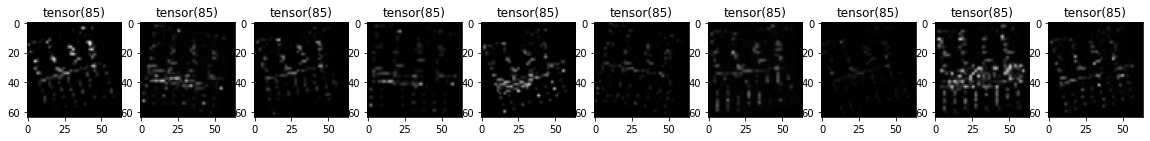

In [14]:
class digit_Dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=True):
        self.root_dir = root_dir
        files = [f[:-4] for root, dir, files in os.walk(root_dir) for f in files]

        dataframe = pd.read_csv(csv_file)
        self.annotations = dataframe[dataframe.filename.isin(files)]

        self.transform = transform

        print(len(self.annotations))
   

    def __len__(self):
         return len(self.annotations)
        
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1], self.annotations.iloc[index, 0])
        image = cv2.imread(img_path + '.jpg')
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))
        # y_label = self.annotations.iloc[index, 1]

        if image is None:
          print(img_path)
       
        if self.transform:
            image = self.transform(image)
        return (image, y_label)


dataset = digit_Dataset(   
    csv_file = "/content/drive/MyDrive/SOFT_COMP_LAB/firmware.csv",
    root_dir = "/content/drive/MyDrive/SOFT_COMP_LAB/imagery",
    transform = transform,
)

len(dataset)

train_set, test_set = torch.utils.data.random_split(dataset, [3050, 763])
train_loader = DataLoader(dataset=train_set, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=20, shuffle=True)

len(train_loader)

data_iter = iter(train_loader)
#images, labels = data_iter.next()
#images.shape

dataiter = iter(train_loader)
images, labels = dataiter.next() 
plt.subplots(figsize=(20, 32))

print(labels[0:10])

for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()

In [15]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3 * 64 * 64, 200)  #flatten the image 
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)  
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        x = self.fc6(x)
        
        return x

net = Net()
net

Net(
  (fc1): Linear(in_features=12288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [16]:
net.cuda()

Net(
  (fc1): Linear(in_features=12288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [17]:
optimizer =  optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# device(type='cuda', index=0)

In [19]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 25
steps = 0
running_loss = 0
print_every = 4000

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,3*64*64))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 

        
                #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,3*64*64))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Test loss: {test_loss/len(test_loader):f} "
                  f"Test accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Finish Train')
torch.save(net.state_dict(), Path)
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 25
steps = 0
running_loss = 0
print_every = 4000

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,3*64*64))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 

        
                #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,3*64*64))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Test loss: {test_loss/len(test_loader):f} "
                  f"Test accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Finish Train')
torch.save(net.state_dict(), Path)

RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')

plt.legend()
plt.grid()
plt.show()

In [ ]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net(X.view(-1,3*64*64))
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net.forward(inputs.view(-1,3*64*64))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
import seaborn as sns
class_names = ["malware","hackware","benigware"]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=20)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=20)
plt.ylabel('True class')
plt.xlabel('Predicted label')